# Machine Learning and Data Analysis

### Project - English language sign recognition using Convolutional Neural Networks

The goal of this project is to develop a convolutional neural network (CNN) model that can recognize English letters from images of hand gestures. The model will be trained and tested on the Sign Language MNIST dataset, which contains 27,455 grayscale images of size 28 by 28 pixels for training and 7,172 images for testing. Each image represents one of the 24 letters of the English alphabet (excluding J and Z) as a hand gesture. The dataset provides a label for each image, ranging from 0 to 25, corresponding to the letter index (A=0, B=1, …, Y=24). The model will learn to map the input images to the output labels using a series of convolutional, pooling, and dense layers. The model performance will be evaluated using metrics such as accuracy, precision, recall, and F1-score on the test set. The project will demonstrate the ability of CNNs to learn features from image data and perform classification tasks. The model will also be integrated with a robotic system that can communicate with humans using sign language. The model will enable the robot to understand the gestures made by humans and respond accordingly. The project will explore the challenges and opportunities of using deep learning for human-robot interaction.

In [268]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPool2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

import warnings
# Ignore warnings
warnings.filterwarnings("ignore")

# LOAD DATA

The dataset used for this project is the Sign Language MNIST dataset, which is available on Kaggle. It is a modified version of the original MNIST dataset of handwritten digits, which is a popular benchmark for image-based machine learning methods. The Sign Language MNIST dataset contains images of hand gestures that represent the 24 letters of the English alphabet (excluding J and Z which require motion). The dataset is designed as a drop-in replacement for the original MNIST dataset and follows the same format and size.

The dataset consists of two CSV files: sign_mnist_train.csv and sign_mnist_test.csv. Each file has a header row of label, pixel1, pixel2, ..., pixel784, which represent a single 28 by 28 pixel image with grayscale values between 0 and 255. The label column contains the class index for each image, ranging from 0 to 25, corresponding to the letter index (A=0, B=1, …, Y=24). The pixel columns contain the pixel values for each image in a row-wise order.

The training file contains 27,455 rows or samples, divided evenly between the 24 classes. The test file contains 7,172 rows or samples, also divided evenly between the 24 classes. The dataset is suitable for multi-class classification tasks and can be used to train and evaluate convolutional neural network models.

In [3]:
TRAINING_DIR = './mnist/sign_mnist_train/sign_mnist_train.csv'
TEST_DIR = './mnist/sign_mnist_test/sign_mnist_test.csv'

train_df = pd.read_csv(TRAINING_DIR)
test_df = pd.read_csv(TEST_DIR)

# Preprocessing

Map the labels with the corresponding letters of the alphabet. This is done to make the output more interpretable and meaningful. For example, the label 0 is mapped to the letter A, the label 1 is mapped to the letter B, and so on. Then seperate label column from dataframe to a seperate pandas series. Next step is to encode the categorical labels using a label binarizer. This is done to convert the labels from integers to one-hot vectors, which are more suitable for multi-class classification tasks. For example, the label 'A' is encoded as [1, 0, 0, …, 0], the label 'B' is encoded as [0, 1, 0, …, 0], and so on. Then normalize the test and train data by dividing them by 255. This is done to scale the pixel values from the range of 0 to 255 to the range of 0 to 1, which can help the model learn faster and better. Another step is to reshape the 784 vector into a 28 by 28 matrix for each sample. This is done to restore the original shape of the images and make them compatible with the convolutional layers of the model. 

In [4]:
letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
labels = list(train_df.label.unique())
label_map = dict()
for idx, letter in enumerate(letters):
    if idx in labels:
        label_map[idx] = letter

In [5]:
train_df["label"] = train_df["label"].replace(label_map)
test_df["label"] = test_df["label"].replace(label_map)

In [6]:
y_train = train_df['label']
y_test = test_df['label']
del train_df['label']
del test_df['label']

In [7]:
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.fit_transform(y_test)

In [8]:
x_train = train_df.values
x_test = test_df.values

In [9]:
x_train = x_train / 255
x_test = x_test / 255

In [10]:
x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)

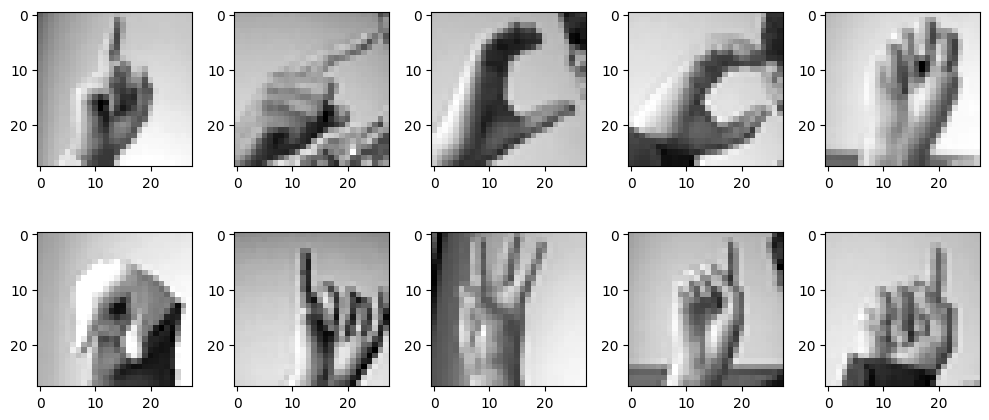

In [11]:
f, ax = plt.subplots(2,5,figsize=(10,5)) 
k = 0
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(x_train[k].reshape(28, 28) , cmap = "gray")    
        k += 1
    plt.tight_layout() 

# Validation Split and Image Augmentation

Apply augmentation to the dataset using an image data generator. This is done to create new variations of the images by applying random transformations such as zooming, shifting, rotating, and flipping. This can help increase the diversity and size of the dataset and prevent overfitting. The image data generator has various parameters that control the type and degree of augmentation. For example, rotation_range=10 means that the images can be rotated up to 10 degrees clockwise or counterclockwise, zoom_range=0.1 means that the images can be zoomed in or out by up to 10%, width_shift_range=0.1 and height_shift_range=0.1 mean that the images can be shifted horizontally or vertically by up to 10% of their width or height, horizontal_flip=False and vertical_flip=False mean that the images cannot be flipped along their axes, and validation_split=0.2 means that 20% of the augmented images will be used for validation. The image data generator can generate batches of augmented images on the fly during training.

In [25]:
train_datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=10,
    zoom_range = 0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False,
    validation_split=0.2
)
test_datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False
)

In [26]:
train_images = train_datagen.flow(
    x=x_train,
    y=y_train,
    subset="training",
    batch_size=32
)

val_images = train_datagen.flow(
    x=x_train,
    y=y_train,
    subset="validation",
    batch_size=32
)

test_images = test_datagen.flow(
    x=x_test,
    y=y_test,
    batch_size=32
)

In [80]:
callback = EarlyStopping(monitor='val_loss', patience=3)
optimizer = Adam(learning_rate=0.001)

# CONVOLUTIONAL NEURAL NETWORK

Convolutional neural networks (CNNs) are a type of artificial neural network that are most commonly used for analyzing visual imagery, such as images, videos, or computer vision tasks. CNNs can also be applied to other types of data, such as speech, audio, or text, that have a spatial or temporal structure.

CNNs are composed of multiple layers that process the input data in a sequential manner, learning hierarchical features and patterns from the data. The main characteristic of CNNs is that they use a mathematical operation called convolution in at least one of their layers, instead of general matrix multiplication. Convolution is a way of applying a filter or a kernel to the input data, which extracts local features and reduces the number of parameters and computations. Convolution can be seen as a sliding window that moves over the input data and produces an output called a feature map.

CNNs typically have three main types of layers: convolutional layers, pooling layers, and fully-connected layers. Each type of layer has a different function and role in the network.

* Convolutional layers are the core building blocks of CNNs. They apply one or more convolutional filters to the input data and produce feature maps that capture the local patterns in the data. Convolutional layers can have different parameters, such as the number, size, and stride of the filters, the padding of the input, and the activation function. Convolutional layers can be stacked on top of each other to form deeper networks that learn more complex and abstract features.

* Pooling layers are another type of layer that are often used after convolutional layers. They perform a downsampling operation on the feature maps, which reduces their spatial dimensions and makes the network more invariant to small translations or distortions in the input. Pooling layers can have different types, such as max pooling, average pooling, or global pooling, depending on how they aggregate the values in each region of the feature map.

* Fully-connected layers are the final type of layer that are usually used at the end of the network. They perform a linear transformation on the flattened vector that comes from the previous layer and produce an output vector that represents the class scores or probabilities for each possible outcome. Fully-connected layers can also have an activation function, such as softmax or sigmoid, to normalize the output.

# MODEL 1

* Total Layers : 5
* Convolutional Layers : 1
    * Number of Filters : 32
    * Filter Shape : 3x3
* Max Pooling Layer : 2x2
* FC Layers : 2
    * Dense Layer with 32 neuron and relu activation
    * Dense Layer with 24 neuron and softmax activation for classification

In [81]:
model1 = keras.Sequential([
        layers.Conv2D(32, (3, 3), activation="relu", input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(32, activation="relu"),
        layers.Dense(24, activation="softmax")
    ])

In [82]:
model1.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history1 = model1.fit(train_images, epochs=50, validation_data=val_images, callbacks=[callback])

Epoch 1/50
687/687 [==============================] - 8s 11ms/step - loss: 3.0346 - accuracy: 0.0822 - val_loss: 2.8369 - val_accuracy: 0.1158
Epoch 2/50
687/687 [==============================] - 8s 11ms/step - loss: 2.7176 - accuracy: 0.1394 - val_loss: 2.6292 - val_accuracy: 0.1592
Epoch 3/50
687/687 [==============================] - 8s 11ms/step - loss: 2.5418 - accuracy: 0.1666 - val_loss: 2.4527 - val_accuracy: 0.1852
Epoch 4/50
687/687 [==============================] - 7s 11ms/step - loss: 2.3762 - accuracy: 0.1986 - val_loss: 2.2968 - val_accuracy: 0.2295
Epoch 5/50
687/687 [==============================] - 7s 11ms/step - loss: 2.1264 - accuracy: 0.2854 - val_loss: 1.9938 - val_accuracy: 0.3203
Epoch 6/50
687/687 [==============================] - 7s 11ms/step - loss: 1.9328 - accuracy: 0.3483 - val_loss: 1.8766 - val_accuracy: 0.3651
Epoch 7/50
687/687 [==============================] - 8s 11ms/step - loss: 1.8312 - accuracy: 0.3832 - val_loss: 1.7919 - val_accuracy: 0.3868

In [83]:
model1.evaluate(test_images)

225/225 [==============================] - 1s 2ms/step - loss: 0.7770 - accuracy: 0.7133


[0.7769938707351685, 0.7133296132087708]

# MODEL 2

Same model with following changes

* Convolutional Layers
    * Number of Filters : 64
* FC Layers
    * Dense Layer with 64 neurons

In [84]:
model2 = keras.Sequential([
        layers.Conv2D(64, (3, 3), activation="relu", input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation="relu"),
        layers.Dense(24, activation="softmax")
    ])

In [85]:
model2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history2 = model2.fit(train_images, epochs=50, validation_data=val_images, callbacks=[callback])

Epoch 1/50
687/687 [==============================] - 9s 13ms/step - loss: 2.0160 - accuracy: 0.3910 - val_loss: 1.4089 - val_accuracy: 0.5680
Epoch 2/50
687/687 [==============================] - 9s 13ms/step - loss: 1.1663 - accuracy: 0.6424 - val_loss: 0.9986 - val_accuracy: 0.6979
Epoch 3/50
687/687 [==============================] - 9s 13ms/step - loss: 0.8694 - accuracy: 0.7286 - val_loss: 0.7895 - val_accuracy: 0.7540
Epoch 4/50
687/687 [==============================] - 9s 13ms/step - loss: 0.7190 - accuracy: 0.7764 - val_loss: 0.6978 - val_accuracy: 0.7769
Epoch 5/50
687/687 [==============================] - 9s 13ms/step - loss: 0.6152 - accuracy: 0.8081 - val_loss: 0.5926 - val_accuracy: 0.8226
Epoch 6/50
687/687 [==============================] - 9s 13ms/step - loss: 0.5464 - accuracy: 0.8299 - val_loss: 0.5926 - val_accuracy: 0.8051
Epoch 7/50
687/687 [==============================] - 9s 13ms/step - loss: 0.4919 - accuracy: 0.8498 - val_loss: 0.4666 - val_accuracy: 0.8558

In [86]:
model2.evaluate(test_images)

225/225 [==============================] - 1s 3ms/step - loss: 0.1081 - accuracy: 0.9663


[0.10809875279664993, 0.9662576913833618]

# MODEL 3

Same model with following changes

* Convolutional Layers
    * Number of Filters : 128
* FC Layers
    * Dense Layer with 128 neuron and relu activation

In [87]:
model3 = keras.Sequential([
        layers.Conv2D(128, (3, 3), activation="relu", input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dense(24, activation="softmax")
    ])

In [88]:
model3.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history3 = model3.fit(train_images, epochs=50, validation_data=val_images, callbacks=[callback])

Epoch 1/50
687/687 [==============================] - 15s 22ms/step - loss: 1.8623 - accuracy: 0.4343 - val_loss: 1.2504 - val_accuracy: 0.6094
Epoch 2/50
687/687 [==============================] - 15s 22ms/step - loss: 1.0140 - accuracy: 0.6769 - val_loss: 0.8684 - val_accuracy: 0.7256
Epoch 3/50
687/687 [==============================] - 15s 22ms/step - loss: 0.7601 - accuracy: 0.7603 - val_loss: 0.6838 - val_accuracy: 0.7807
Epoch 4/50
687/687 [==============================] - 15s 22ms/step - loss: 0.6199 - accuracy: 0.8064 - val_loss: 0.5750 - val_accuracy: 0.8239
Epoch 5/50
687/687 [==============================] - 15s 22ms/step - loss: 0.5319 - accuracy: 0.8338 - val_loss: 0.5383 - val_accuracy: 0.8252
Epoch 6/50
687/687 [==============================] - 15s 22ms/step - loss: 0.4670 - accuracy: 0.8593 - val_loss: 0.4396 - val_accuracy: 0.8552
Epoch 7/50
687/687 [==============================] - 15s 22ms/step - loss: 0.4024 - accuracy: 0.8745 - val_loss: 0.3870 - val_accuracy:

In [90]:
model3.evaluate(test_images)

225/225 [==============================] - 1s 6ms/step - loss: 0.0741 - accuracy: 0.9679


[0.07412035018205643, 0.9679308533668518]

# MODEL 4

Same model with following changes,

* Added Droupout of 0.1 for convolutional layer
* Added Batch Normalization
* Added Dropout of 0.1 for first FC layer


Dropout and batch normalization are two techniques that are often used in deep learning models to improve their performance and prevent overfitting. They have different functions and effects on the network, and they can be used together or separately depending on the problem and the architecture.

* Dropout is a regularization technique that randomly drops out a fraction of the units in a layer during training. This means that some units are temporarily set to zero and do not contribute to the forward or backward pass. Dropout helps prevent overfitting by reducing the co-adaptation of features and forcing the network to learn more robust and generalizable representations. Dropout can be applied to any type of layer, such as convolutional, pooling, or fully-connected layers. Dropout has a parameter called the dropout rate, which controls the probability of dropping out each unit. A common value for the dropout rate is 0.5, but it can vary depending on the problem and the layer.

* Batch normalization is a technique that normalizes the input distribution of each layer during training. This means that each input is subtracted by its mean and divided by its standard deviation, computed over a mini-batch of samples. Batch normalization helps speed up the training and improve the generalization by reducing the internal covariate shift, which is the change in the input distribution caused by the updates of previous layers. Batch normalization can also have a slight regularization effect, as it adds some noise to the inputs. Batch normalization is usually applied to convolutional or fully-connected layers, before or after the activation function. Batch normalization has four parameters: two scale and shift parameters that are learned during training, and two running mean and variance parameters that are updated during training and used during inference.

In [92]:
model4 = keras.Sequential([
        layers.Conv2D(128, (3, 3), activation="relu", input_shape=(28, 28, 1)),
        layers.Dropout(0.1),
        layers.BatchNormalization(),    
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(24, activation="softmax")
    ])
model4.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history4 = model4.fit(train_images, epochs=50, validation_data=val_images, callbacks=[callback])

Epoch 1/50
687/687 [==============================] - 31s 44ms/step - loss: 1.8757 - accuracy: 0.4160 - val_loss: 1.9399 - val_accuracy: 0.4966
Epoch 2/50
687/687 [==============================] - 31s 45ms/step - loss: 0.9445 - accuracy: 0.6782 - val_loss: 0.6804 - val_accuracy: 0.7713
Epoch 3/50
687/687 [==============================] - 31s 45ms/step - loss: 0.6645 - accuracy: 0.7745 - val_loss: 0.7482 - val_accuracy: 0.7773
Epoch 4/50
687/687 [==============================] - 31s 46ms/step - loss: 0.5000 - accuracy: 0.8303 - val_loss: 0.6051 - val_accuracy: 0.7887
Epoch 5/50
687/687 [==============================] - 31s 45ms/step - loss: 0.3946 - accuracy: 0.8671 - val_loss: 0.2663 - val_accuracy: 0.9077
Epoch 6/50
687/687 [==============================] - 31s 45ms/step - loss: 0.3321 - accuracy: 0.8886 - val_loss: 0.2683 - val_accuracy: 0.9057
Epoch 7/50
687/687 [==============================] - 31s 46ms/step - loss: 0.2789 - accuracy: 0.9063 - val_loss: 0.5058 - val_accuracy:

In [93]:
model4.evaluate(test_images)

225/225 [==============================] - 2s 8ms/step - loss: 0.0912 - accuracy: 0.9734


[0.09124863147735596, 0.9733686447143555]

# MODEL 5

* Total Layers : 7
* Convolutional Layers : 2
    * Number of Filters : 32
    * Filter Shape : 3x3
* Max Pooling Layer : 2x2
* FC Layers : 2
    * Dense Layer with 64 neuron and relu activation
    * Dense Layer with 24 neuron and softmax activation for classification

In [94]:
model5 = keras.Sequential([
        layers.Conv2D(32, (3, 3), activation="relu", input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(32, (3, 3), activation="relu"),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation="relu"),
        layers.Dense(24, activation="softmax")
    ])
model5.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history5 = model5.fit(train_images, epochs=50, validation_data=val_images, callbacks=[callback])

Epoch 1/50
687/687 [==============================] - 9s 12ms/step - loss: 2.2013 - accuracy: 0.3289 - val_loss: 1.4803 - val_accuracy: 0.5331
Epoch 2/50
687/687 [==============================] - 8s 12ms/step - loss: 1.1474 - accuracy: 0.6244 - val_loss: 0.9447 - val_accuracy: 0.6844
Epoch 3/50
687/687 [==============================] - 8s 12ms/step - loss: 0.8256 - accuracy: 0.7258 - val_loss: 0.7562 - val_accuracy: 0.7352
Epoch 4/50
687/687 [==============================] - 8s 12ms/step - loss: 0.6672 - accuracy: 0.7781 - val_loss: 0.6414 - val_accuracy: 0.7911
Epoch 5/50
687/687 [==============================] - 9s 12ms/step - loss: 0.5736 - accuracy: 0.8065 - val_loss: 0.5140 - val_accuracy: 0.8310
Epoch 6/50
687/687 [==============================] - 8s 12ms/step - loss: 0.4938 - accuracy: 0.8342 - val_loss: 0.5133 - val_accuracy: 0.8241
Epoch 7/50
687/687 [==============================] - 8s 12ms/step - loss: 0.4417 - accuracy: 0.8535 - val_loss: 0.4064 - val_accuracy: 0.8596

# MODEL 6

* Total Layers : 7
* Convolutional Layers : 2
    * Number of Filters : 32, 64
    * Filter Shape : 3x3
* Max Pooling Layer : 2x2
* FC Layers : 2
    * Dense Layer with 128 neuron and relu activation
    * Dense Layer with 24 neuron and softmax activation for classification

In [95]:
model6 = keras.Sequential([
        layers.Conv2D(32, (3, 3), activation="relu", input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation="relu"),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dense(24, activation="softmax")
    ])
model6.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history6 = model6.fit(train_images, epochs=50, validation_data=val_images, callbacks=[callback])
model6.evaluate(test_images)

Epoch 1/50
687/687 [==============================] - 9s 12ms/step - loss: 1.7039 - accuracy: 0.4682 - val_loss: 0.9761 - val_accuracy: 0.6808
Epoch 2/50
687/687 [==============================] - 8s 12ms/step - loss: 0.7270 - accuracy: 0.7639 - val_loss: 0.6132 - val_accuracy: 0.7989
Epoch 3/50
687/687 [==============================] - 8s 12ms/step - loss: 0.4831 - accuracy: 0.8435 - val_loss: 0.4414 - val_accuracy: 0.8601
Epoch 4/50
687/687 [==============================] - 9s 12ms/step - loss: 0.3718 - accuracy: 0.8803 - val_loss: 0.3334 - val_accuracy: 0.8915
Epoch 5/50
687/687 [==============================] - 9s 12ms/step - loss: 0.2992 - accuracy: 0.9032 - val_loss: 0.3043 - val_accuracy: 0.8998
Epoch 6/50
687/687 [==============================] - 9s 13ms/step - loss: 0.2539 - accuracy: 0.9185 - val_loss: 0.2394 - val_accuracy: 0.9242
Epoch 7/50
687/687 [==============================] - 9s 13ms/step - loss: 0.2277 - accuracy: 0.9239 - val_loss: 0.2200 - val_accuracy: 0.9270

[0.04402802884578705, 0.990379273891449]

# MODEL 7

* Total Layers : 7
* Convolutional Layers : 2
    * Number of Filters : 64, 128
    * Filter Shape : 3x3
* Max Pooling Layers : 2x2
* FC Layers : 2
    * Dense Layer with 128 neuron and relu activation
    * Dense Layer with 24 neuron and softmax activation for classification

In [96]:
model7 = keras.Sequential([
        layers.Conv2D(64, (3, 3), activation="relu", input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation="relu"),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dense(24, activation="softmax")
    ])
model7.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history7 = model7.fit(train_images, epochs=50, validation_data=val_images, callbacks=[callback])
model7.evaluate(test_images)

Epoch 1/50
687/687 [==============================] - 11s 16ms/step - loss: 1.5823 - accuracy: 0.5036 - val_loss: 0.7309 - val_accuracy: 0.7642
Epoch 2/50
687/687 [==============================] - 11s 16ms/step - loss: 0.5532 - accuracy: 0.8188 - val_loss: 0.4459 - val_accuracy: 0.8514
Epoch 3/50
687/687 [==============================] - 11s 16ms/step - loss: 0.3713 - accuracy: 0.8768 - val_loss: 0.2985 - val_accuracy: 0.9022
Epoch 4/50
687/687 [==============================] - 11s 16ms/step - loss: 0.2687 - accuracy: 0.9137 - val_loss: 0.2399 - val_accuracy: 0.9221
Epoch 5/50
687/687 [==============================] - 11s 16ms/step - loss: 0.2106 - accuracy: 0.9318 - val_loss: 0.2590 - val_accuracy: 0.9093
Epoch 6/50
687/687 [==============================] - 11s 16ms/step - loss: 0.1702 - accuracy: 0.9477 - val_loss: 0.1518 - val_accuracy: 0.9536
Epoch 7/50
687/687 [==============================] - 11s 17ms/step - loss: 0.1411 - accuracy: 0.9549 - val_loss: 0.1148 - val_accuracy:

[0.03553921356797218, 0.9870328903198242]

# MODEL 8

* Total Layers : 12
* Convolutional Layers : 2
    * Number of Filters : 32, 64
    * Filter Shape : 3x3
* Droupout layers: 2(.01)
* Batch Normalization
* Max Pooling Layer : 2x2
* FC Layers : 2
    * Dense Layer with 128 neuron and relu activation
    * Dropout layer : .02
    * Dense Layer with 24 neuron and softmax activation for classification
    

In [97]:
model8 = keras.Sequential([
        layers.Conv2D(32, (3, 3), activation="relu", input_shape=(28, 28, 1)),
        layers.Dropout(0.1),
        layers.BatchNormalization(),    
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation="relu"),
        layers.Dropout(0.1),
        layers.BatchNormalization(),    
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(24, activation="softmax")
    ])
model8.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history8 = model8.fit(train_images, epochs=50, validation_data=val_images, callbacks=[callback])
model8.evaluate(test_images)

Epoch 1/50
687/687 [==============================] - 13s 18ms/step - loss: 1.1048 - accuracy: 0.6444 - val_loss: 0.9051 - val_accuracy: 0.6886
Epoch 2/50
687/687 [==============================] - 13s 19ms/step - loss: 0.3825 - accuracy: 0.8712 - val_loss: 1.0278 - val_accuracy: 0.7365
Epoch 3/50
687/687 [==============================] - 13s 19ms/step - loss: 0.2391 - accuracy: 0.9191 - val_loss: 1.2517 - val_accuracy: 0.6884
Epoch 4/50
687/687 [==============================] - 13s 19ms/step - loss: 0.1745 - accuracy: 0.9430 - val_loss: 0.5324 - val_accuracy: 0.8255
Epoch 5/50
687/687 [==============================] - 13s 19ms/step - loss: 0.1416 - accuracy: 0.9516 - val_loss: 0.1691 - val_accuracy: 0.9488
Epoch 6/50
687/687 [==============================] - 13s 19ms/step - loss: 0.1163 - accuracy: 0.9610 - val_loss: 1.4037 - val_accuracy: 0.6944
Epoch 7/50
687/687 [==============================] - 13s 19ms/step - loss: 0.1040 - accuracy: 0.9654 - val_loss: 0.1097 - val_accuracy:

[0.04785425588488579, 0.9841048717498779]

# Evaluation

In [222]:
trained_models = [model1, model2, model3, model4, model5, model6, model7, model8]

In [280]:
histories = [history1, history2, history3, history4, history5, history6, history7, history8]

In [281]:
acc = [history.history['accuracy'] for history in histories]
val_acc = [history.history['val_accuracy'] for history in histories]
loss = [history.history['loss'] for history in histories]
val_loss = [history.history['val_loss'] for history in histories]

In [252]:
names = ["1 Conv Layer\n32 Filter","1 Conv Layer\n64 Filter","1 Conv Layer\n128 Filter","1 Conv Layer\n128 Filter\nDropout, Batch Norm","2 Conv Layers\n32,32 Filters","2 Conv Layers\n32,64 Filters","2 Conv Layers\n64,128 Filter","2 Conv Layer\nBatch Norm and Dropout"]

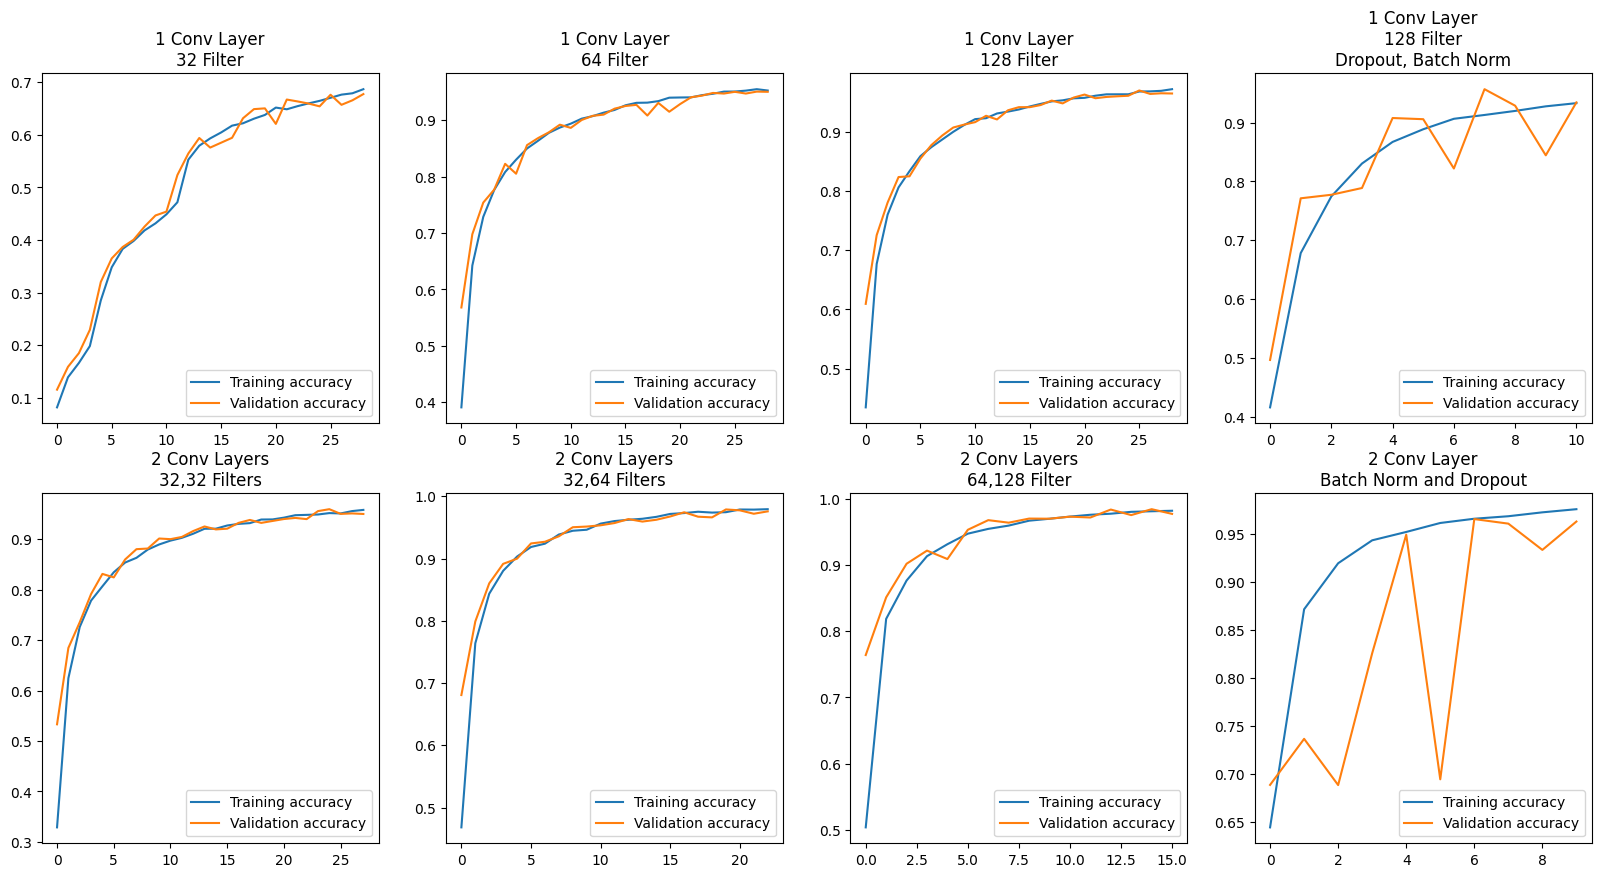

In [288]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
for i, ax in enumerate(axes.flatten()):
    ax.plot(range(len(acc[i])), acc[i], label='Training accuracy')
    ax.plot(range(len(val_acc[i])), val_acc[i], label='Validation accuracy')
    ax.set_title(names[i])
    ax.legend()
plt.show()

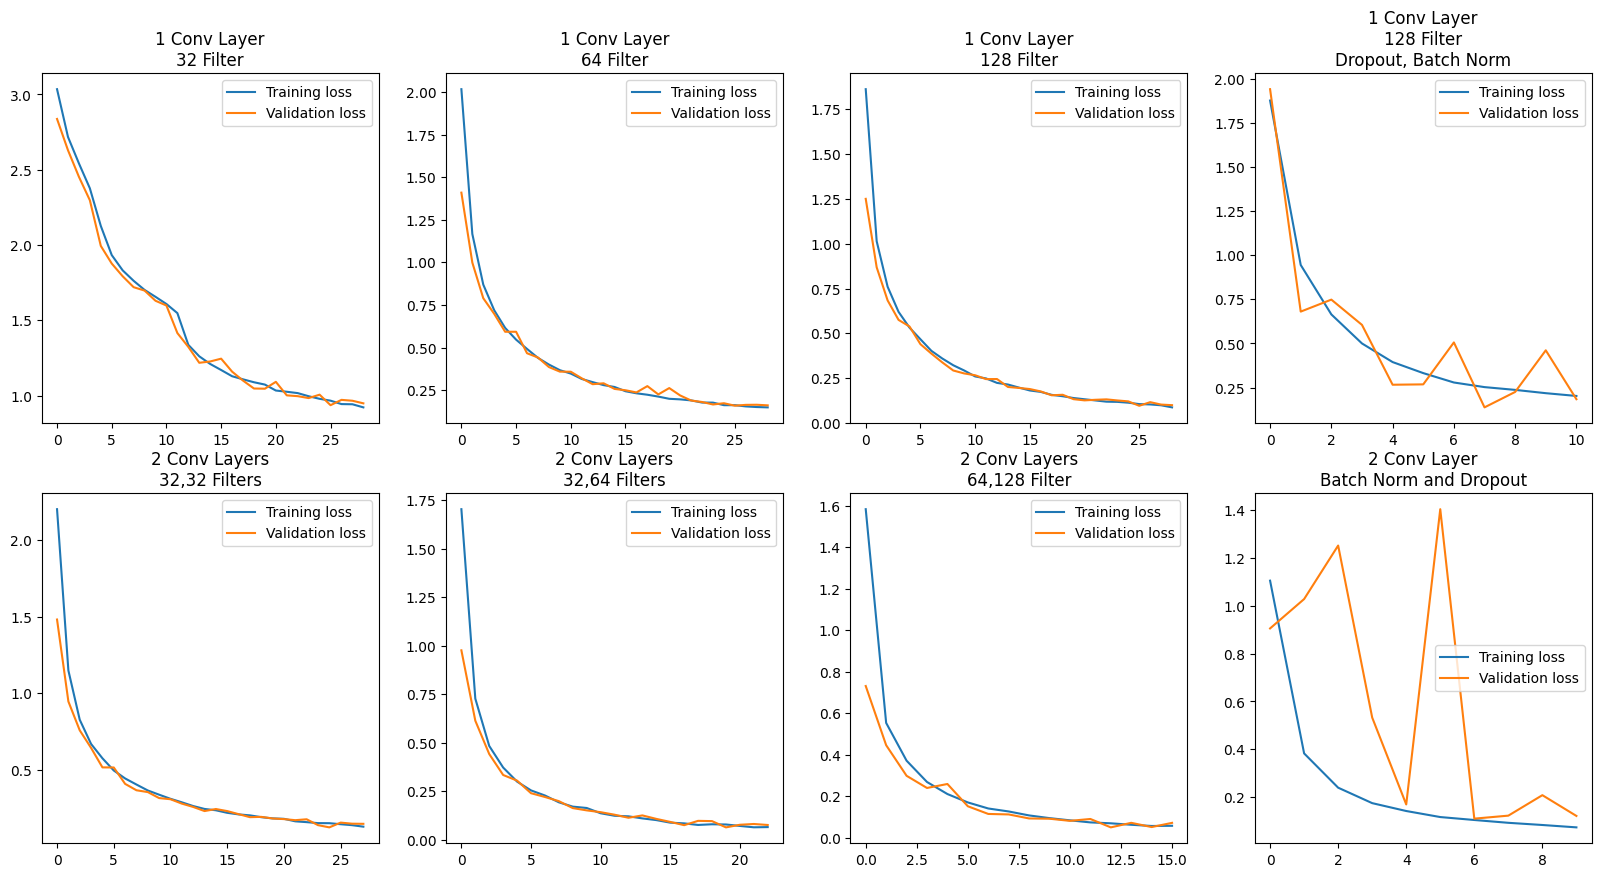

In [287]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
for i, ax in enumerate(axes.flatten()):
    ax.plot(range(len(loss[i])), loss[i], label='Training loss')
    ax.plot(range(len(val_loss[i])), val_loss[i], label='Validation loss')
    ax.set_title(names[i])
    ax.legend()
plt.show()

In [247]:
accuracy_list = []
precision_list = []
recall_list = []
f1_score_list = []
cm_list = []
report_list = []
for model in trained_models:
    predictions = model.predict(x_test)
    y_pred = np.argmax(predictions,axis=1)
    y_truth = np.argmax(y_test,axis=1)
    report_list.append(classification_report(y_truth, y_pred))
    cm_list.append(confusion_matrix(y_truth, y_pred))
    accuracy_list.append(accuracy_score(y_truth,y_pred))
    precision_list.append(precision_score(y_truth,y_pred, average='weighted'))
    recall_list.append(recall_score(y_truth,y_pred, average='weighted'))
    f1_score_list.append(f1_score(y_truth,y_pred, average='weighted'))

225/225 [==============================] - 1s 4ms/step


In [256]:
import pandas as pd

df = pd.DataFrame({
    "accuracy": accuracy_list,
    "precision": precision_list,
    "recall": recall_list,
    "f1_score": f1_score_list,
    "labels": names
})


In [257]:
df_melted = df.melt(id_vars="labels", var_name="variable", value_name="value")

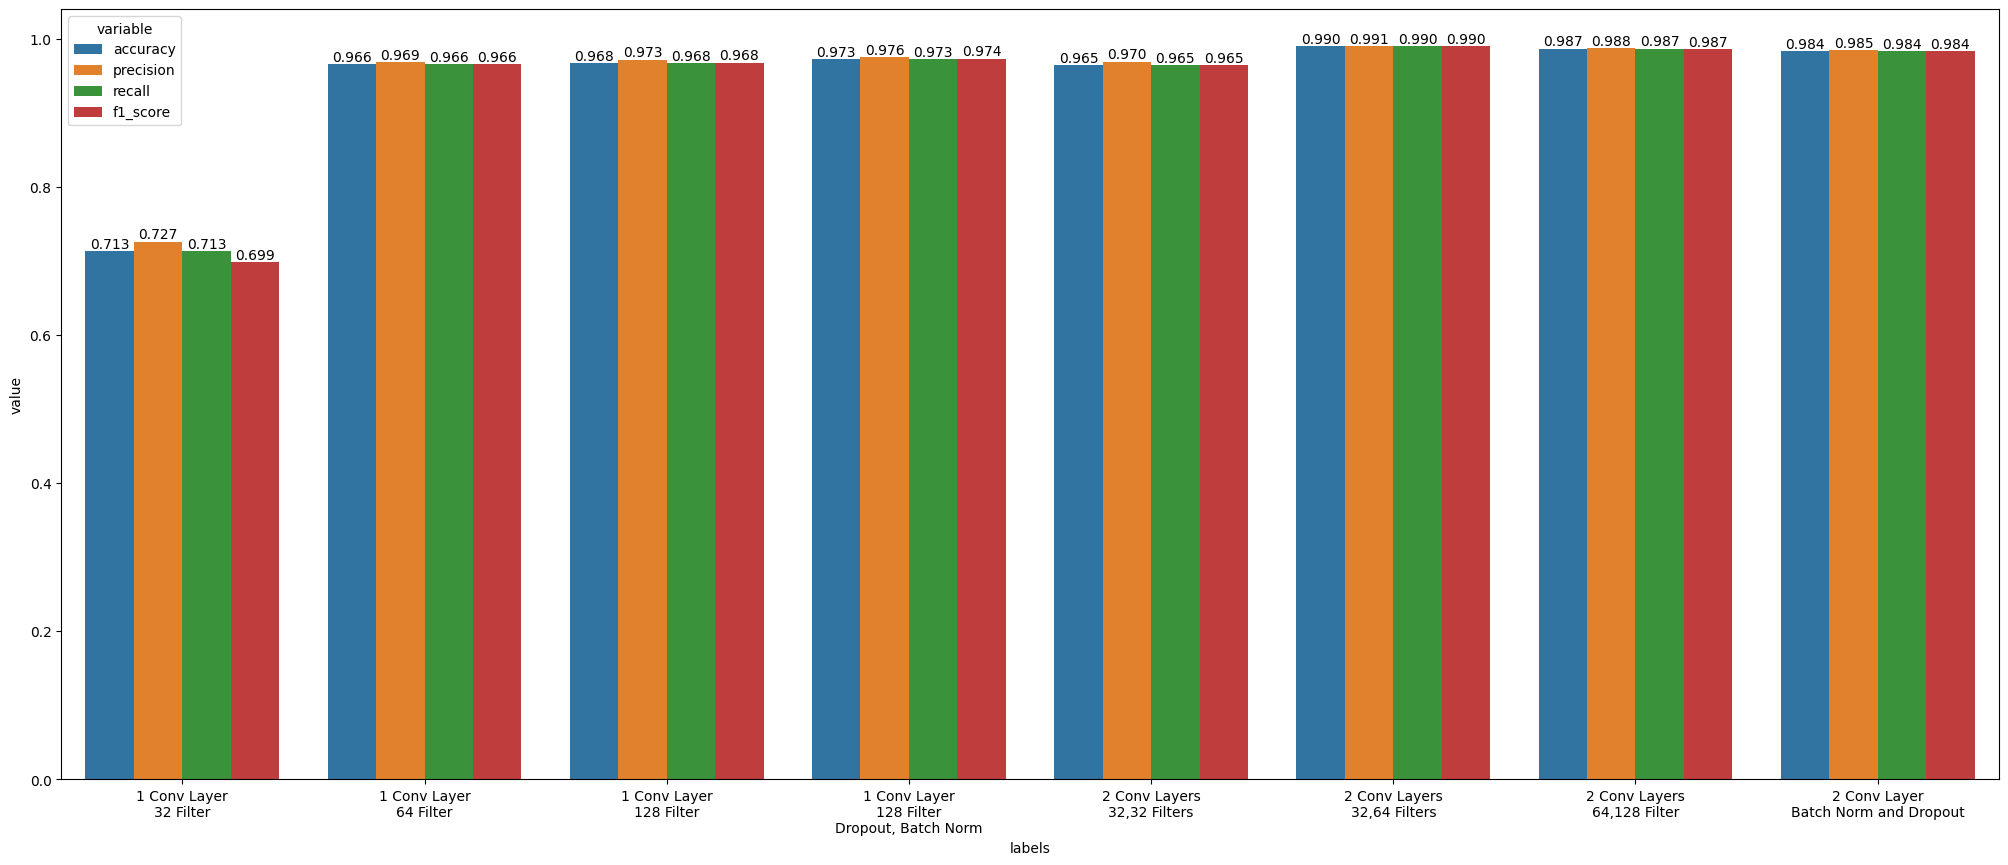

In [265]:
plt.figure(figsize=(25,10))
ax = sns.barplot(x="labels", y="value", hue="variable", data=df_melted)
for c in ax.containers:
    ax.bar_label(c, fmt="%.3f")

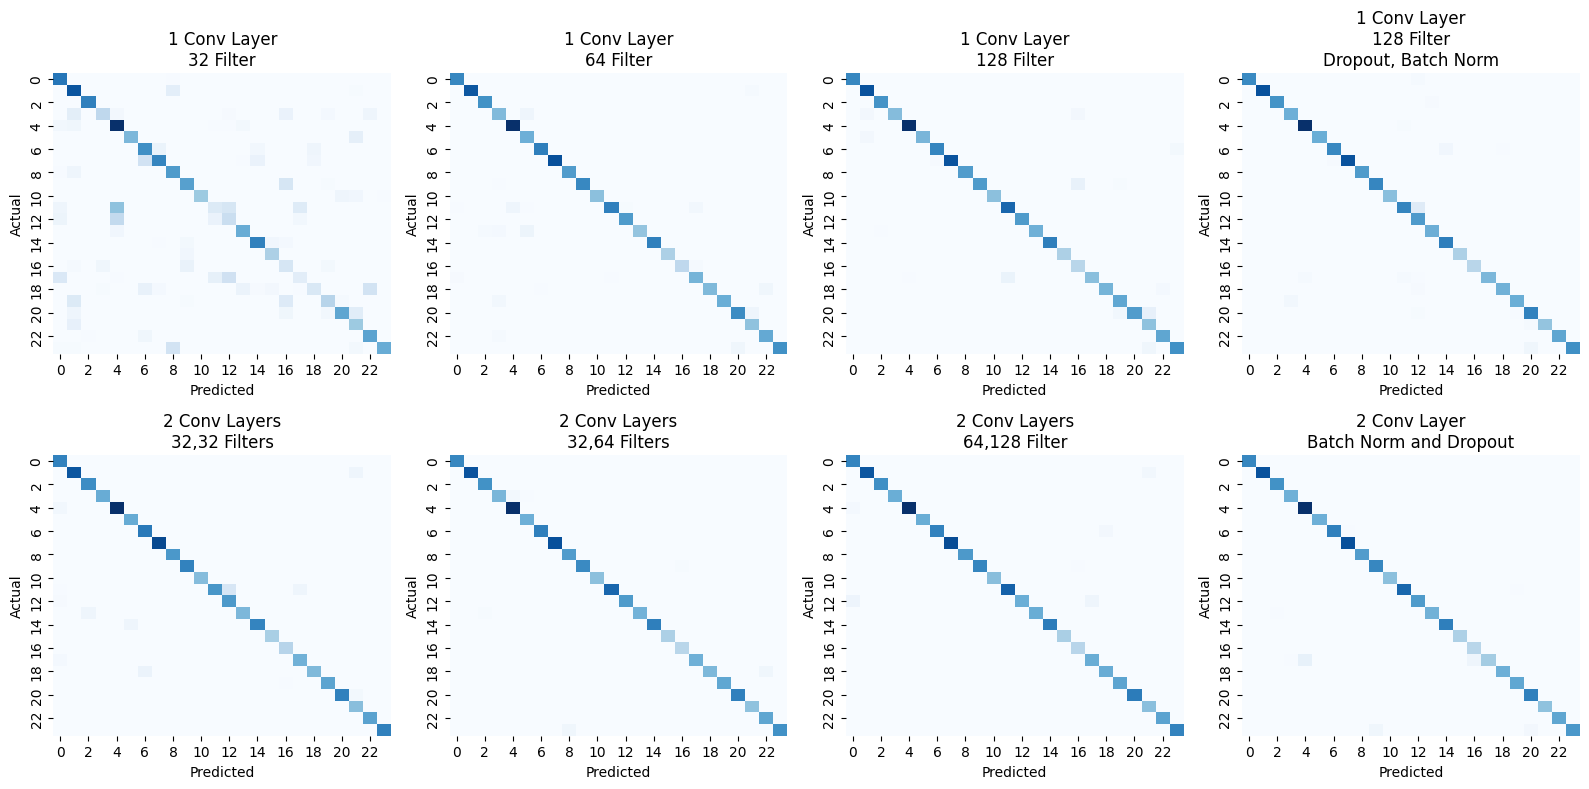

In [267]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))

for ax, name, matrix in zip(axes.flatten(), names, cm_list):
    sns.heatmap(matrix, fmt="d", cmap="Blues", cbar=False, ax=ax)
    ax.set_title(name)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.tight_layout()
plt.show()

In [272]:
print(report_list[0])

              precision    recall  f1-score   support

           0       0.71      0.99      0.83       331
           1       0.64      0.89      0.74       432
           2       0.99      1.00      1.00       310
           3       0.84      0.49      0.62       245
           4       0.57      0.90      0.70       498
           5       1.00      0.83      0.91       247
           6       0.67      0.82      0.74       348
           7       0.88      0.69      0.77       436
           8       0.67      0.91      0.77       288
           9       0.79      0.76      0.78       331
          10       0.99      0.80      0.89       209
          11       0.45      0.15      0.23       394
          12       0.37      0.35      0.36       291
          13       0.85      0.93      0.89       246
          14       0.86      0.89      0.87       347
          15       0.84      0.90      0.86       164
          16       0.28      0.52      0.36       144
          17       0.40    

In [273]:
print(report_list[1])

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       331
           1       1.00      0.98      0.99       432
           2       0.97      1.00      0.99       310
           3       0.86      0.91      0.88       245
           4       0.96      1.00      0.98       498
           5       0.82      1.00      0.90       247
           6       0.99      1.00      1.00       348
           7       1.00      1.00      1.00       436
           8       1.00      1.00      1.00       288
           9       1.00      0.99      1.00       331
          10       1.00      1.00      1.00       209
          11       0.99      0.88      0.93       394
          12       0.99      1.00      0.99       291
          13       1.00      0.81      0.89       246
          14       1.00      1.00      1.00       347
          15       0.99      1.00      1.00       164
          16       1.00      0.94      0.97       144
          17       0.90    

In [274]:
print(report_list[2])

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       331
           1       0.94      1.00      0.97       432
           2       0.99      1.00      1.00       310
           3       1.00      0.89      0.94       245
           4       1.00      1.00      1.00       498
           5       1.00      0.94      0.97       247
           6       0.98      0.96      0.97       348
           7       1.00      0.99      0.99       436
           8       1.00      1.00      1.00       288
           9       1.00      0.88      0.93       331
          10       1.00      1.00      1.00       209
          11       0.92      1.00      0.96       394
          12       1.00      1.00      1.00       291
          13       1.00      0.99      1.00       246
          14       1.00      1.00      1.00       347
          15       1.00      1.00      1.00       164
          16       0.74      1.00      0.85       144
          17       1.00    

In [275]:
print(report_list[3])

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       331
           1       1.00      1.00      1.00       432
           2       1.00      0.98      0.99       310
           3       0.94      1.00      0.97       245
           4       0.98      0.99      0.99       498
           5       1.00      1.00      1.00       247
           6       0.98      0.94      0.96       348
           7       1.00      0.98      0.99       436
           8       1.00      1.00      1.00       288
           9       1.00      1.00      1.00       331
          10       1.00      1.00      1.00       209
          11       0.96      0.84      0.90       394
          12       0.78      1.00      0.88       291
          13       0.97      1.00      0.99       246
          14       0.95      1.00      0.97       347
          15       1.00      1.00      1.00       164
          16       0.99      1.00      1.00       144
          17       1.00    

In [276]:
print(report_list[4])

              precision    recall  f1-score   support

           0       0.90      1.00      0.95       331
           1       1.00      0.95      0.98       432
           2       0.93      1.00      0.96       310
           3       1.00      1.00      1.00       245
           4       1.00      0.97      0.98       498
           5       0.92      1.00      0.96       247
           6       0.92      1.00      0.96       348
           7       1.00      1.00      1.00       436
           8       1.00      1.00      1.00       288
           9       1.00      1.00      1.00       331
          10       1.00      1.00      1.00       209
          11       1.00      0.74      0.85       394
          12       0.79      0.98      0.87       291
          13       1.00      0.90      0.95       246
          14       1.00      0.94      0.97       347
          15       1.00      1.00      1.00       164
          16       0.98      1.00      0.99       144
          17       0.91    

In [277]:
print(report_list[5])

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       331
           1       1.00      1.00      1.00       432
           2       0.98      1.00      0.99       310
           3       1.00      0.94      0.97       245
           4       0.98      1.00      0.99       498
           5       0.99      1.00      0.99       247
           6       1.00      1.00      1.00       348
           7       1.00      1.00      1.00       436
           8       0.94      1.00      0.97       288
           9       1.00      0.98      0.99       331
          10       1.00      1.00      1.00       209
          11       1.00      1.00      1.00       394
          12       1.00      1.00      1.00       291
          13       1.00      0.98      0.99       246
          14       1.00      1.00      1.00       347
          15       1.00      1.00      1.00       164
          16       0.97      1.00      0.98       144
          17       1.00    

In [278]:
print(report_list[6])

              precision    recall  f1-score   support

           0       0.90      1.00      0.95       331
           1       1.00      0.96      0.98       432
           2       1.00      1.00      1.00       310
           3       1.00      1.00      1.00       245
           4       1.00      0.98      0.99       498
           5       1.00      1.00      1.00       247
           6       1.00      0.96      0.98       348
           7       1.00      1.00      1.00       436
           8       1.00      1.00      1.00       288
           9       1.00      0.99      1.00       331
          10       1.00      1.00      1.00       209
          11       1.00      1.00      1.00       394
          12       1.00      0.84      0.91       291
          13       1.00      1.00      1.00       246
          14       1.00      1.00      1.00       347
          15       1.00      1.00      1.00       164
          16       0.98      1.00      0.99       144
          17       0.92    

In [279]:
print(report_list[7])

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       331
           1       1.00      1.00      1.00       432
           2       0.99      1.00      1.00       310
           3       0.99      1.00      1.00       245
           4       0.93      1.00      0.96       498
           5       1.00      1.00      1.00       247
           6       1.00      0.99      1.00       348
           7       0.99      1.00      1.00       436
           8       1.00      1.00      1.00       288
           9       0.94      1.00      0.97       331
          10       1.00      1.00      1.00       209
          11       1.00      0.99      1.00       394
          12       1.00      1.00      1.00       291
          13       1.00      0.99      0.99       246
          14       1.00      1.00      1.00       347
          15       1.00      1.00      1.00       164
          16       0.85      1.00      0.92       144
          17       1.00    